In [2]:
import pandas as pd
import numpy as np

import yfinance as yf

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

import plotly.graph_objs as go


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--> Fetching Bitcoin Price Data

In [3]:
data = yf.download(tickers='BTC-USD', start='2018-01-01', end='2019-12-31', interval='1d')

data.reset_index(inplace=True)

data['Date'] = pd.to_datetime(data['Date'])

data

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...,...
724,2019-12-26,7238.966797,7388.302734,7200.386719,7274.799316,22787010034
725,2019-12-27,7290.088379,7363.529297,7189.934082,7238.141113,22777360996
726,2019-12-28,7317.990234,7399.041016,7286.905273,7289.031250,21365673026


In [16]:
data['Date'].values

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-20T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28

In [4]:
# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], 
                name = 'Bitcoin Data'))

--> Data Preparation

In [5]:
# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Remove timezone from timestamp
df['ds'] = df['ds'].dt.tz_localize(None)

# Take a look at the data
df.head()

C:\Users\Malhar.Pandya\AppData\Local\Temp\ipykernel_20888\235667408.py:2: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Price,ds,y
Ticker,,BTC-USD
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           729 non-null    datetime64[ns]
 1   (Close, BTC-USD)   729 non-null    float64       
 2   (High, BTC-USD)    729 non-null    float64       
 3   (Low, BTC-USD)     729 non-null    float64       
 4   (Open, BTC-USD)    729 non-null    float64       
 5   (Volume, BTC-USD)  729 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 34.3 KB


In [15]:
ds_data = df['ds'].values

ds_data

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-20T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28

In [20]:
y_data = df['y'].values

y_data = y_data.flatten()

In [21]:
new_dataset = pd.DataFrame({
    'ds': pd.to_datetime(ds_data),  # Ensure 'ds' is in datetime format
    'y': y_data  # Use the 'y' values as they are
})

new_dataset

,ds,y
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000
...,...,...
724,2019-12-26,7238.966797
725,2019-12-27,7290.088379
726,2019-12-28,7317.990234
727,2019-12-29,7422.652832


In [23]:
df_train = new_dataset[new_dataset['ds']<='2019-11-30']
df_test = new_dataset[new_dataset['ds']>'2019-11-30']

In [24]:
df_train

,ds,y
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000
...,...,...
694,2019-11-26,7218.371094
695,2019-11-27,7531.663574
696,2019-11-28,7463.105957
697,2019-11-29,7761.243652


In [30]:
df_test

,ds,y
699,2019-12-01,7424.292480
700,2019-12-02,7321.988281
701,2019-12-03,7320.145508
702,2019-12-04,7252.034668
703,2019-12-05,7448.307617
704,2019-12-06,7546.996582
705,2019-12-07,7556.237793
706,2019-12-08,7564.345215
707,2019-12-09,7400.899414
708,2019-12-10,7278.119629


--> Building and training a model

In [25]:
model = Prophet(interval_width=0.95, n_changepoints=7)\

model.fit(df_train)

10:09:25 - cmdstanpy - INFO - Chain [1] start processing
10:09:25 - cmdstanpy - INFO - Chain [1] done processing
10:09:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:09:25 - cmdstanpy - INFO - Chain [1] start processing
10:09:25 - cmdstanpy - INFO - Chain [1] done processing


--> Using the model to make predictions

In [26]:
future = model.make_future_dataframe(periods=31)

forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
725,2019-12-27,7398.818561,5542.937572,9242.915332
726,2019-12-28,7424.776023,5544.861658,9435.561235
727,2019-12-29,7379.085947,5441.354605,9377.420962
728,2019-12-30,7374.771228,5338.635148,9305.642925
729,2019-12-31,7314.024762,5328.341062,9290.071990


In [27]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,13209.609144,11674.065501,14937.179999,13209.609144,13209.609144,34.950936,34.950936,34.950936,34.950936,34.950936,34.950936,0.0,0.0,0.0,13244.560080
1,2018-01-02,13150.691807,11189.340818,14858.747674,13150.691807,13150.691807,-4.596926,-4.596926,-4.596926,-4.596926,-4.596926,-4.596926,0.0,0.0,0.0,13146.094881
2,2018-01-03,13091.774470,11252.379307,14894.320918,13091.774470,13091.774470,-21.147183,-21.147183,-21.147183,-21.147183,-21.147183,-21.147183,0.0,0.0,0.0,13070.627287
3,2018-01-04,13032.857133,11280.972205,14779.935528,13032.857133,13032.857133,-65.234863,-65.234863,-65.234863,-65.234863,-65.234863,-65.234863,0.0,0.0,0.0,12967.622270
4,2018-01-05,12973.939796,11222.672642,14669.360464,12973.939796,12973.939796,-4.597541,-4.597541,-4.597541,-4.597541,-4.597541,-4.597541,0.0,0.0,0.0,12969.342255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2019-12-27,7403.416102,5542.937572,9242.915332,6613.916526,8286.809568,-4.597541,-4.597541,-4.597541,-4.597541,-4.597541,-4.597541,0.0,0.0,0.0,7398.818561
726,2019-12-28,7382.217498,5544.861658,9435.561235,6555.161520,8303.551712,42.558524,42.558524,42.558524,42.558524,42.558524,42.558524,0.0,0.0,0.0,7424.776023
727,2019-12-29,7361.018895,5441.354605,9377.420962,6492.422872,8372.583955,18.067052,18.067052,18.067052,18.067052,18.067052,18.067052,0.0,0.0,0.0,7379.085947
728,2019-12-30,7339.820292,5338.635148,9305.642925,6354.282922,8447.324273,34.950936,34.950936,34.950936,34.950936,34.950936,34.950936,0.0,0.0,0.0,7374.771228


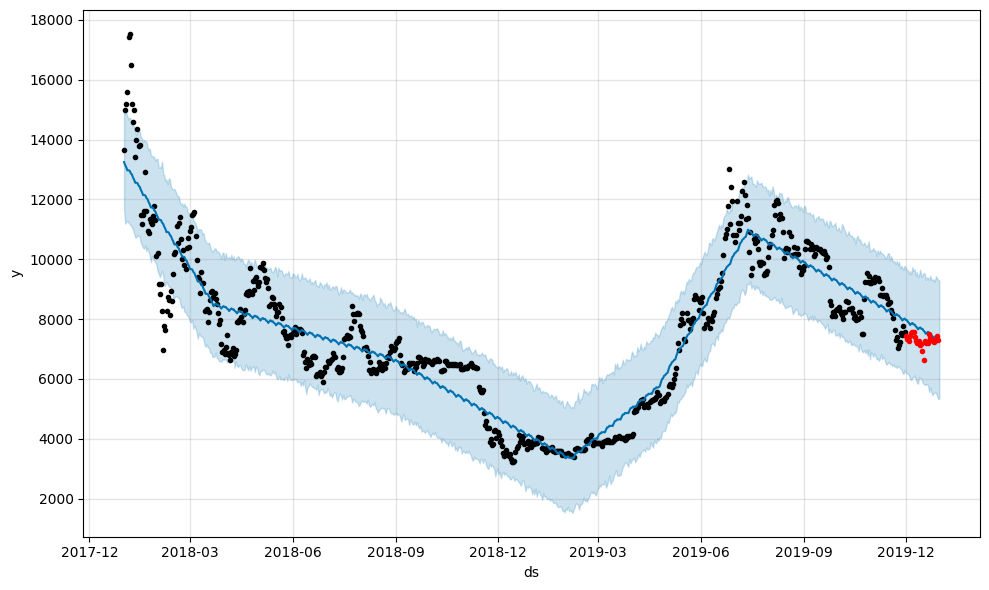

In [31]:
fig = model.plot(forecast)
ax = fig.gca()
ax.plot(df_test['ds'], df_test['y'], 'r.')

--> Time Series Decomposition

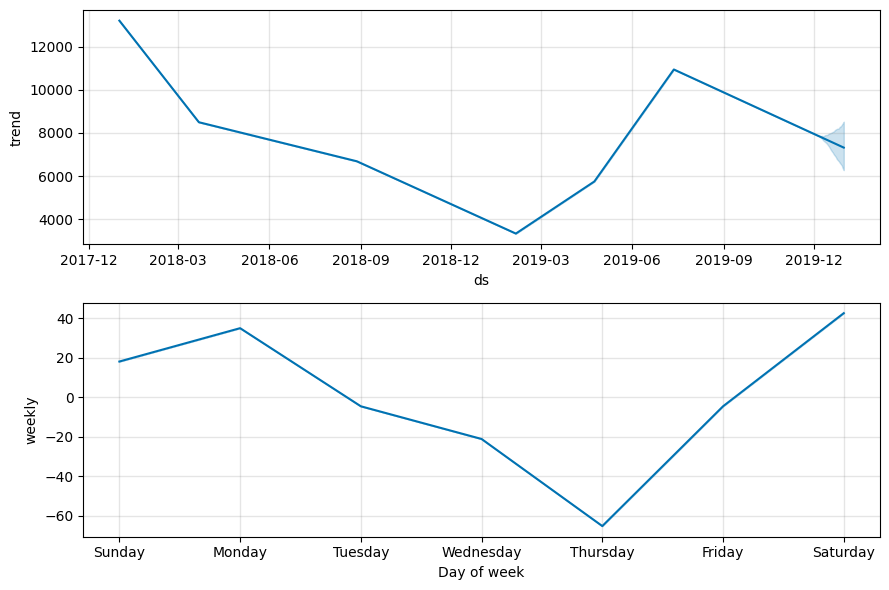

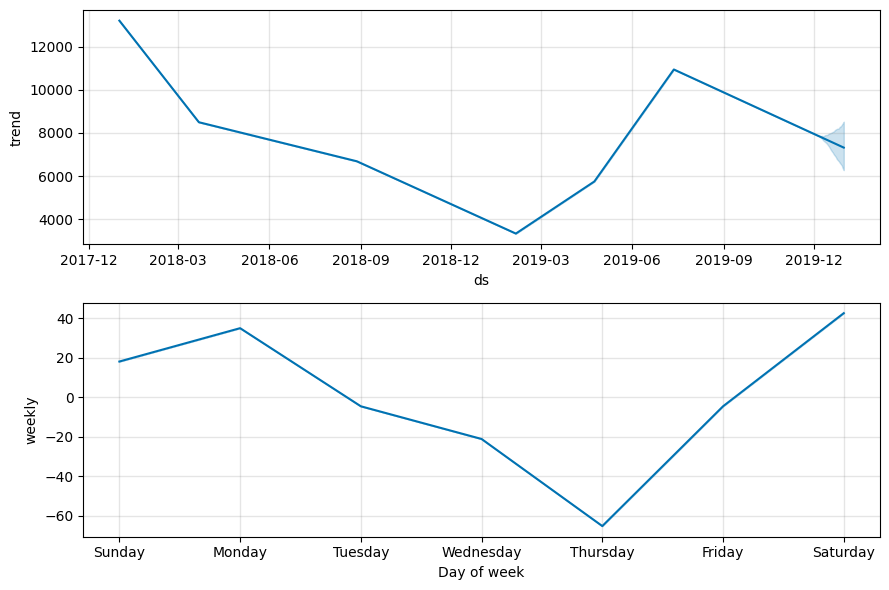

In [32]:
model.plot_components(forecast)

--> Identifying change points

In [34]:
print(len(model.changepoints))

model.changepoints

7


80    2018-03-22
159   2018-06-09
239   2018-08-28
319   2018-11-16
399   2019-02-04
478   2019-04-24
558   2019-07-13
Name: ds, dtype: datetime64[ns]

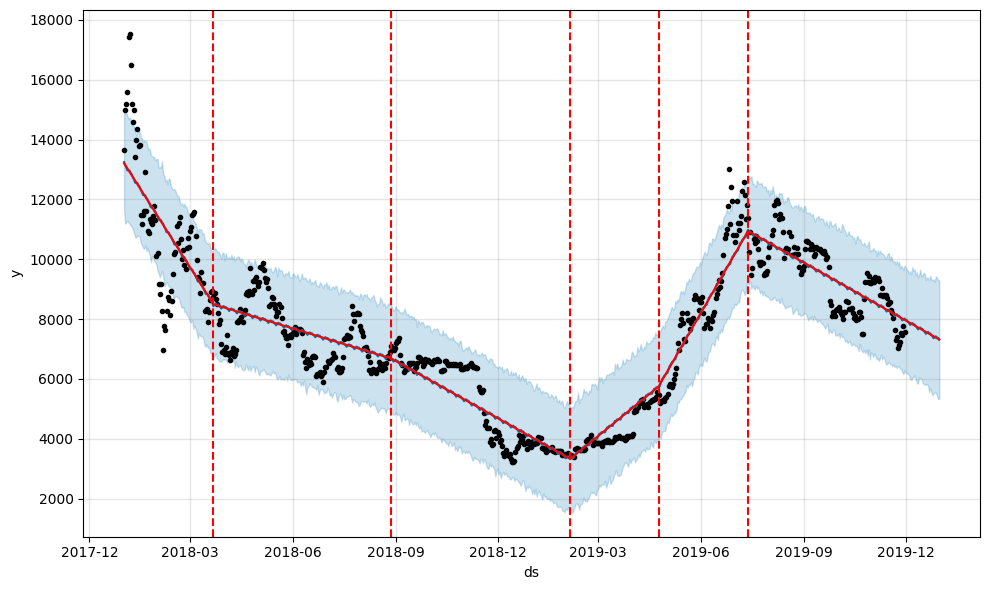

In [36]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

--> Cross Validation

In [37]:
df_cv = cross_validation(model, initial='500 days', period='60 days', horizon='30 days', parallel='processes')

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-04,10318.828106,8332.610177,12146.938299,11215.437500,2019-07-03
1,2019-07-05,10451.685885,8694.916511,12259.981238,10978.459961,2019-07-03
2,2019-07-06,10574.317384,8731.679288,12331.426669,11208.550781,2019-07-03
3,2019-07-07,10600.439884,8699.458270,12473.378899,11450.846680,2019-07-03
4,2019-07-08,10641.019380,8880.209620,12460.620423,12285.958008,2019-07-03


--> Performance Evaluation

In [38]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.128724e+06,1062.414278,804.902658,0.075460,0.056585,0.072109,1.000000
1,4 days,1.046248e+06,1022.862698,793.138129,0.073941,0.056585,0.070928,1.000000
2,5 days,1.479993e+06,1216.549477,972.893392,0.089389,0.074266,0.086599,0.888889
3,6 days,1.939016e+06,1392.485481,1162.559230,0.104969,0.133888,0.102907,0.777778
4,7 days,2.212985e+06,1487.610398,1258.811272,0.113111,0.133888,0.110921,0.666667


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



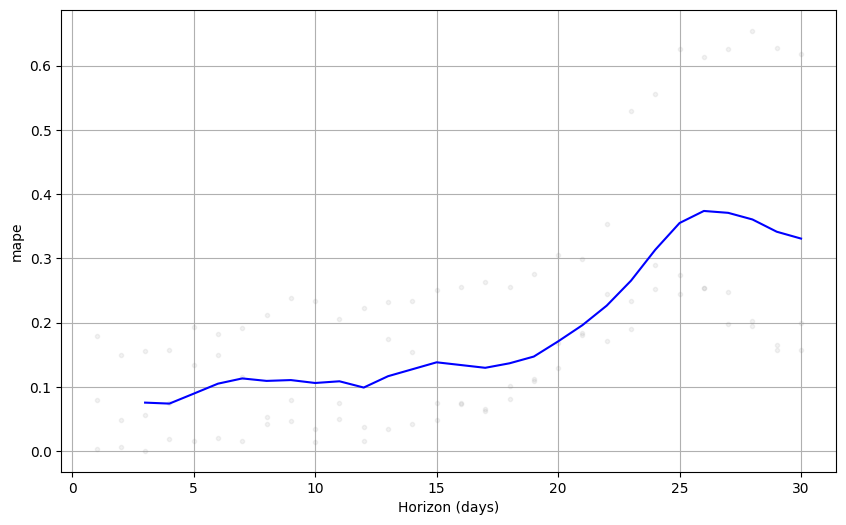

In [39]:
fig = plot_cross_validation_metric(df_cv, metric='mape')